# Semi-Supervised Text Classification Using EM

## About Dataset
This dataset is collected from https://www.kaggle.com/datasets/wanderfj/enron-spam. It contains two folders of spam and ham. Each folder contains emails.

## OVERVIEW
This directory contains the Enron-Spam datasets, as described in the 
paper:

V. Metsis, I. Androutsopoulos and G. Paliouras, "Spam Filtering with 
Naive Bayes - Which Naive Bayes?". Proceedings of the 3rd Conference 
on Email and Anti-Spam (CEAS 2006), Mountain View, CA, USA, 2006.

The "preprocessed" subdirectory contains the messages in the 
preprocessed format that was used in the experiments of the paper.
Each message is in a separate text file. The number at the beginning
of each filename is the "order of arrival".

The "raw" subdirectory contains the messages in their original form. 
Spam messages in non-Latin encodings, ham messages sent by the owners 
of the mailboxes to themselves (sender in "To:", "Cc:", or "Bcc" 
field), and a handful of virus-infected messages have been removed, 
but no other modification has been made. The messages in the "raw" 
subdirectory are more than the corresponding messages in the 
"preprocessed" subdirectory, because: (a) duplicates are preserved 
in the "raw" form, and (b) during the preprocessing, ham and/or spam 
messages were randomly subsampled to obtain the desired ham:spam 
ratios. See the paper for further details.

The Enron-Spam datasets are available from: 
<http://www.iit.demokritos.gr/skel/i-config/> and
<http://www.aueb.gr/users/ion/publications.html>.

The paper is available from:
<http://www.ceas.cc/> and 
<http://www.aueb.gr/users/ion/publications.html>.

V. Metsis, I. Androutsopoulos and G. Paliouras  

This file last updated: June 19, 2006.

https://www.kaggle.com/datasets/venky73/spam-mails-dataset

In [1]:
import sys
import os
os.chdir('../')

path = os.getcwd()
if path not in sys.path:
    sys.path.append(path)

In [2]:
# basic
import pandas as pd
import numpy as np
# preprocessing
import re
from lib.preprocessing import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# model
from sklearn.naive_bayes import MultinomialNB
from lib.semi_sup_EM import semi_sup_EM, semi_sup_EM_sklearn
from sklearn.linear_model import SGDClassifier
# visualization
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt

# Data

In [308]:
df_1 = pd.read_json(
    "data/enron_spam_full/train.jsonl", lines=True, dtype={"label": int}
).set_index("message_id", drop=True)
df_2 = pd.read_json(
    "data/enron_spam_full/test.jsonl", lines=True, dtype={"label": int}
).set_index("message_id", drop=True)
df = pd.concat([df_1, df_2], axis=0).rename(
    columns={"label": "label_num", "label_text": "label"})
df.label_num.value_counts()

label_num
1    17171
0    16545
Name: count, dtype: int64

In [105]:
df_1 = pd.read_json(
    "data/enron_spam_full/train.jsonl", lines=True, dtype={"label": int}
).set_index("message_id", drop=True)
df_2 = pd.read_json(
    "data/enron_spam_full/test.jsonl", lines=True, dtype={"label": int}
).set_index("message_id", drop=True)
df = pd.concat([df_1, df_2], axis=0).rename(
    columns={"label": "label_num", "label_text": "label"}
)[["label", "text", "label_num"]]
df.index.name = None
drop_indices = np.random.choice(df.query("label_num == 1").index, 15000, replace=False)
df.drop(drop_indices, inplace = True)
# =============================================================================
# label - Labels of Emails which can be either Spam or Ham;
# text - Emails data;
# label_num - if spam it's 1, or else it's 0;
print(df.label.value_counts())
df

label
ham     16545
spam     2171
Name: count, dtype: int64


label                                               text  label_num
11929   ham  perspective on ferc regulatory action client c...          0
2209    ham  enron / hpl actuals for december 11 , 2000 tec...          0
5458    ham  fortune most admired ranking congratulations !...          0
11027  spam  localized software , all languages available ....          1
22721   ham  re : risk position - eugenio perez ? ? ? ? tha...          0
...     ...                                                ...        ...
6578    ham  re : book notes vince : look forward to meetin...          0
128     ham  rollout schedule for unify real - time deal / ...          0
8485    ham  anshuman shrivastava sandeep : vince has asked...          0
7311    ham  re : good morning john ,\ni shall see christie...          0
27915   ham  customer meeting ngts , whose main headquarter...          0

[18716 rows x 3 columns]

In [100]:
# df = pd.read_csv(
#     'data/spam_mails/spam_ham_dataset.csv',
#     delimiter=",",
#     index_col=[0],
#     dtype={'label_num': int})
# # =============================================================================
# # label - Labels of Emails which can be either Spam or Ham;
# # text - Emails data;
# # label_num - if spam it's 1, or else it's 0;
# print(df.label.value_counts())
# df

label
ham     3672
spam    1499
Name: count, dtype: int64


label                                               text  label_num
605    ham  Subject: enron methanol ; meter # : 988291\r\n...          0
2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...          0
3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...          0
4685  spam  Subject: photoshop , windows , office . cheap ...          1
2030   ham  Subject: re : indian springs\r\nthis deal is t...          0
...    ...                                                ...        ...
1518   ham  Subject: put the 10 on the ft\r\nthe transport...          0
404    ham  Subject: 3 / 4 / 2000 and following noms\r\nhp...          0
2933   ham  Subject: calpine daily gas nomination\r\n>\r\n...          0
1409   ham  Subject: industrial worksheets for august 2000...          0
4807  spam  Subject: important online banking alert\r\ndea...          1

[5171 rows x 3 columns]

# Preprocessing

In [106]:
# Clean and tokenize
df_clean = df.copy()
df_clean['text'] = df_clean['text'].apply(lambda x: re.subn('\r\n|\n\r', '',x)[0])
df_clean['text'] = list(map(tokenize, df_clean['text']))
df_clean = df_clean.loc[:, ['text', 'label_num']]
df_clean

text  label_num
11929  perspective on ferc regulatory action client c...          0
2209   enron   hpl actuals for december 11   2000 tec...          0
5458   fortune most admired ranking congratulations  ...          0
11027  localized software   all languages available  ...          1
22721  re   risk position   eugenio perez         tha...          0
...                                                  ...        ...
6578   re   book notes vince   look forward to meetin...          0
128    rollout schedule for unify real   time deal   ...          0
8485   anshuman shrivastava sandeep   vince has asked...          0
7311   re   good morning john   i shall see christie ...          0
27915  customer meeting ngts   whose main headquarter...          0

[18716 rows x 2 columns]

# Bag of words - model

In [107]:
n = df_clean.shape[0]
vectotizer = CountVectorizer()

df_vec = vectotizer.fit_transform(df_clean["text"])
y_vec = df_clean["label_num"]

X = df_vec.copy()
y = y_vec.copy()

# Train test split

In [148]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
    X, y, test_size=0.95, random_state=42)

X_unlabeled, X_test, y_unlabeled, y_test = train_test_split(
    X_unlabeled, y_unlabeled, test_size=0.05, random_state=42)

print(
    "Train tweets number: {}\nTest tweets number: {}".format(
        X_labeled.shape[0], X_test.shape[0]
    )
)

print("\nNumber of each class in table: ")
print("\n--labeled train set--")
i = 0.0
for _ in y_labeled.value_counts():
    print(f"{i} -> {_}")
    i += 1.0
print("\n--unlabeled train set--")
i = 0.0
for _ in y_unlabeled.value_counts():
    print(f"{i} -> {_}")
    i += 1.0
print("\n--test set--")
i = 0.0
for _ in y_test.value_counts():
    print(f"{i} -> {_}")
    i += 1.0

Train tweets number: 935
Test tweets number: 890

Number of each class in table: 

--labeled train set--
0.0 -> 843
1.0 -> 92

--unlabeled train set--
0.0 -> 14912
1.0 -> 1979

--test set--
0.0 -> 790
1.0 -> 100


# Basic EM algorithm for semi-supervised learning of a text classifier

In [109]:
EM_result = semi_sup_EM(
    X_labeled_=X_labeled,
    y_labeled_=y_labeled,
    X_ul_=X_unlabeled,
    X_test_=X_test,
    y_test_=y_test,
    alpha_=1,#.385,
    max_iter_=100,
)


Confusion Matrix:
 [[1576    3]
 [ 161   39]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1579
           1       0.93      0.20      0.32       200

    accuracy                           0.91      1779
   macro avg       0.92      0.60      0.64      1779
weighted avg       0.91      0.91      0.88      1779



KeyboardInterrupt: 

In [149]:
mnb = semi_sup_EM_sklearn()
mnb.fit_EM(X_labeled, y_labeled, X_unlabeled, X_test)
print(confusion_matrix(np.array(y_test), mnb.predict(X_test)))
print(classification_report(np.array(y_test), mnb.predict(X_test)))

[[787   3]
 [ 62  38]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       790
           1       0.93      0.38      0.54       100

    accuracy                           0.93       890
   macro avg       0.93      0.69      0.75       890
weighted avg       0.93      0.93      0.91       890



In [150]:
mnb = semi_sup_EM_sklearn(beta=0.0001)
mnb.fit_EM(X_labeled, y_labeled, X_unlabeled, X_test)
print(confusion_matrix(np.array(y_test), mnb.predict(X_test)))
print(classification_report(np.array(y_test), mnb.predict(X_test)))

[[788   2]
 [ 44  56]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       790
           1       0.97      0.56      0.71       100

    accuracy                           0.95       890
   macro avg       0.96      0.78      0.84       890
weighted avg       0.95      0.95      0.94       890



In [151]:
mnb = semi_sup_EM_sklearn(alpha=0.385, beta=0.0001)
EM_sklearn_result = mnb.fit_EM(X_labeled, y_labeled, X_unlabeled, X_test)
print(confusion_matrix(np.array(y_test), mnb.predict(X_test)))
print(classification_report(np.array(y_test), mnb.predict(X_test)))

[[788   2]
 [ 39  61]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       790
           1       0.97      0.61      0.75       100

    accuracy                           0.95       890
   macro avg       0.96      0.80      0.86       890
weighted avg       0.95      0.95      0.95       890



##

# Learning curve visualization

In [153]:
log_theta_iter = [val[0] for val in EM_result[1].values()]
y_pred_iter = [val[1] for val in EM_result[1].values()]
log_theta_iter_sklearn = [val[0] for val in EM_sklearn_result[1].values()]
y_pred_iter_sklearn = [val[1] for val in EM_sklearn_result[1].values()]

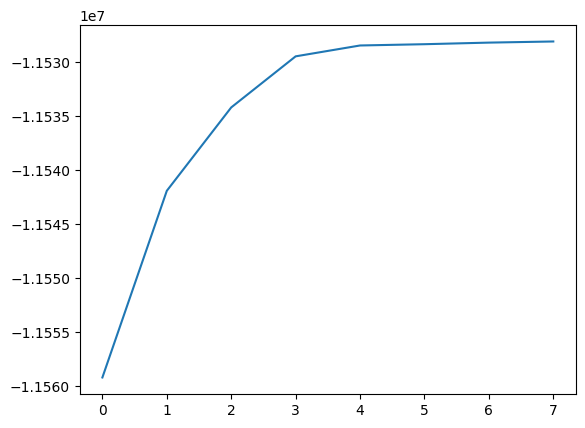

In [114]:
plt.plot(log_theta_iter)

In [ ]:
for i in range(len(y_pred_iter)):
    print("Iteration {}".format(i))
    print(confusion_matrix(np.array(y_test), y_pred_iter[i]),"\n")

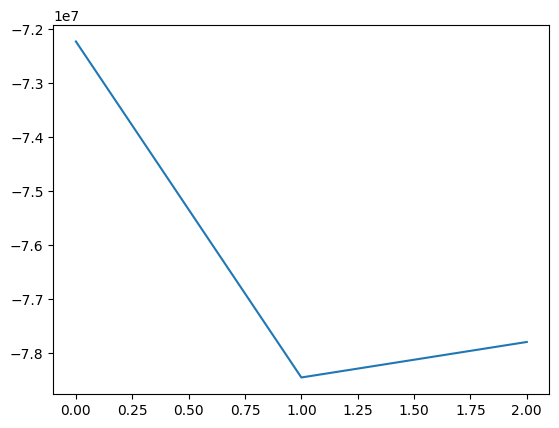

In [116]:
plt.plot(log_theta_iter_sklearn)

In [117]:
for i in range(len(y_pred_iter_sklearn)):
    print("Iteration {}".format(i))
    print(confusion_matrix(np.array(y_test), y_pred_iter_sklearn[i]),"\n")

Iteration 0
[[1574    5]
 [ 120   80]] 

Iteration 1
[[1576    3]
 [  86  114]] 

Iteration 2
[[1576    3]
 [  78  122]] 



# Classical model vs EM with weigths on unlabeled data

In [118]:
classic_nb = MultinomialNB()
classic_nb.fit(X_labeled, y_labeled)

MultinomialNB()

In [119]:
print(confusion_matrix(np.array(y_unlabeled), classic_nb.predict(X_unlabeled)))
print(classification_report(np.array(y_unlabeled), classic_nb.predict(X_unlabeled)))

[[14102    21]
 [ 1507   372]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     14123
           1       0.95      0.20      0.33      1879

    accuracy                           0.90     16002
   macro avg       0.93      0.60      0.64     16002
weighted avg       0.91      0.90      0.88     16002



In [120]:
print(confusion_matrix(np.array(y_unlabeled), mnb.predict(X_unlabeled)))
print(classification_report(np.array(y_unlabeled), mnb.predict(X_unlabeled)))

[[14072    51]
 [  733  1146]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     14123
           1       0.96      0.61      0.75      1879

    accuracy                           0.95     16002
   macro avg       0.95      0.80      0.86     16002
weighted avg       0.95      0.95      0.95     16002



# General visualizations

In [298]:
X_test, X_, y_test, y_ = train_test_split(X, y, test_size=0.9, random_state=42)

em_scores = []
mnb_scores = []
sgd_scores = []
lin_reg_scores = []
ratios = []

step = 0.05
for r in np.arange(0 + step, 1, step):

    X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(
        X_, y_, test_size=r, random_state=42
    )

    print('y_labeled: {}; y_unlabeled: {}'.format(y_labeled.count(), y_unlabeled.count()))

    ratio = round(y_unlabeled.count() / y_labeled.count(),2)
    ratios.append(ratio)

    beta_ratio = y_labeled.sum() / y_unlabeled.count() / 100

    # print('EM')
    em_mnb = semi_sup_EM_sklearn(alpha=0.385, beta=beta_ratio, prnt=False)
    EM_sklearn_result = em_mnb.fit_EM(X_labeled, y_labeled, X_unlabeled, X_test)
    # print(confusion_matrix(np.array(y_test), em_mnb.predict(X_test)))
    # print(classification_report(np.array(y_test), em_mnb.predict(X_test)))

    score = balanced_accuracy_score(
        y_true=np.array(y_test), y_pred=em_mnb.predict(X_test)
    )

    em_scores.append(score)

    # print("mNB")
    classic_mnb = MultinomialNB()
    classic_mnb.fit(X_labeled, y_labeled)
    # print(confusion_matrix(np.array(y_unlabeled), classic_mnb.predict(X_unlabeled)))
    # print(classification_report(np.array(y_unlabeled), classic_mnb.predict(X_unlabeled)))

    score = balanced_accuracy_score(
        y_true=np.array(y_test), y_pred=classic_mnb.predict(X_test)
    )

    mnb_scores.append(score)

    sgd = Pipeline([#('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
    sgd.fit(X_labeled, y_labeled)

    score = balanced_accuracy_score(
        y_true=np.array(y_test), y_pred=sgd.predict(X_test)
    )

    sgd_scores.append(score)

    lin_reg = Pipeline([#('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='log_loss', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
    lin_reg.fit(X_labeled, y_labeled)

    score = balanced_accuracy_score(
        y_true=np.array(y_test), y_pred=lin_reg.predict(X_test)
    )

    lin_reg_scores.append(score)

y_labeled: 843; y_unlabeled: 16002
y_labeled: 1685; y_unlabeled: 15160
y_labeled: 2527; y_unlabeled: 14318
y_labeled: 3369; y_unlabeled: 13476
y_labeled: 4212; y_unlabeled: 12633
y_labeled: 5054; y_unlabeled: 11791
y_labeled: 5896; y_unlabeled: 10949
y_labeled: 6738; y_unlabeled: 10107
y_labeled: 7581; y_unlabeled: 9264
y_labeled: 8423; y_unlabeled: 8422
y_labeled: 9265; y_unlabeled: 7580
y_labeled: 10108; y_unlabeled: 6737
y_labeled: 10950; y_unlabeled: 5895
y_labeled: 11792; y_unlabeled: 5053
y_labeled: 12634; y_unlabeled: 4211
y_labeled: 13476; y_unlabeled: 3369
y_labeled: 14319; y_unlabeled: 2526
y_labeled: 15161; y_unlabeled: 1684
y_labeled: 16003; y_unlabeled: 842


C:\Users\User\AppData\Local\Temp\ipykernel_7452\1716792761.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=12)


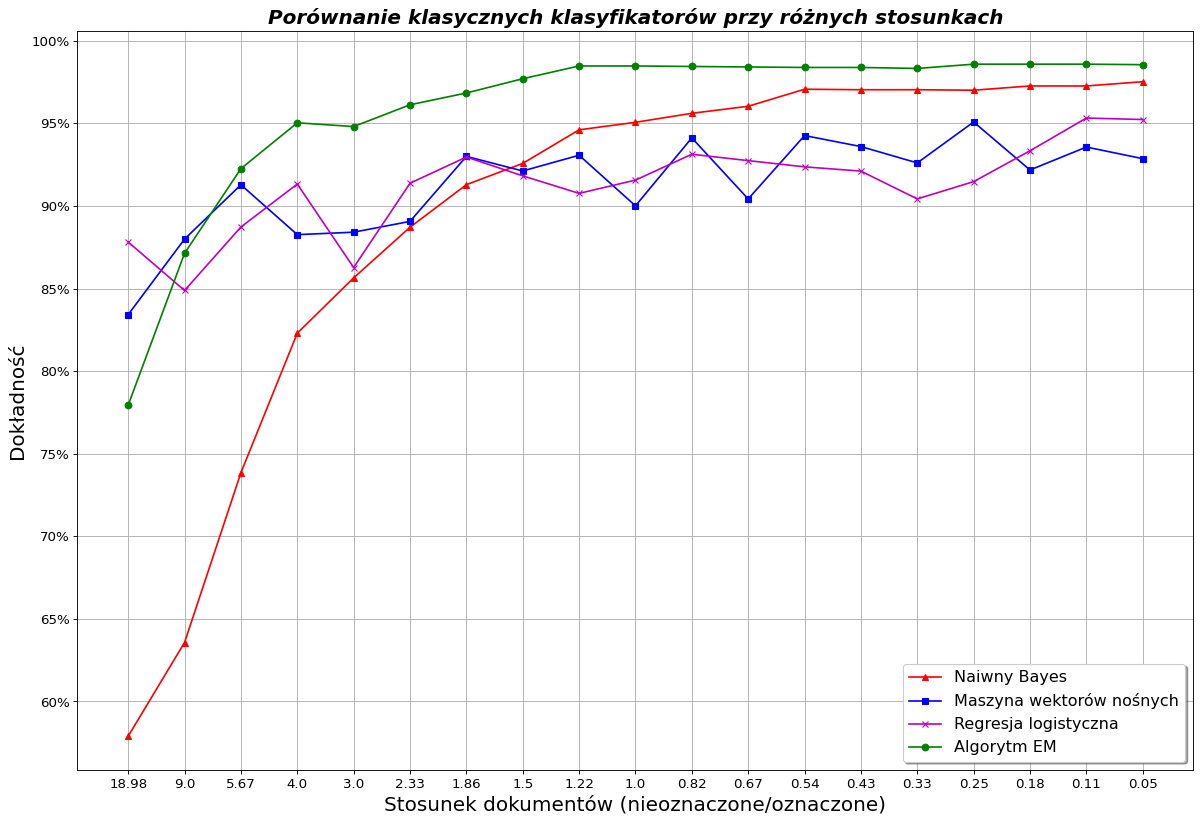

In [300]:
t = np.arange(0.0, len(em_scores))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(18, 12), dpi=80)
# fig.set_figwidth(18)
# fig.set_figheight(12)

ax.plot(t, mnb_scores, "r-^", label="Naiwny Bayes")
ax.plot(t, sgd_scores, "b-s", label="Maszyna wektorów nośnych")
ax.plot(t, lin_reg_scores, "m-x", label="Regresja logistyczna")
ax.plot(t, em_scores, "g-o", label="Algorytm EM")

ax.set_title(
    "Porównanie klasycznych klasyfikatorów przy różnych stosunkach",
    fontsize=18,
    fontweight="bold",
    style="italic",
)
ax.set_xticks(t, ratios)
ax.grid(True)
ax.set_ylabel("Dokładność", fontsize=18)
ax.set_xlabel("Stosunek dokumentów (nieoznaczone/oznaczone)", fontsize=18)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=12)
ax.set_xticklabels(ratios, fontsize=12)

legend = ax.legend(loc="lower right", shadow=True, fontsize="x-large")

plt.show()


In [291]:
X_test, X_, y_test, y_ = train_test_split(X, y, test_size=0.9, random_state=42)

em_scores = {}

for i in range(6):

    X_unlabeled_, X_labeled, y_unlabeled_, y_labeled = train_test_split(
            X_, y_, test_size=100*2**i, random_state=42
        )
    
    temp = []

    for r in range(8):
        
        _, X_unlabeled, _, y_unlabeled = train_test_split(
            X_unlabeled_, y_unlabeled_, test_size=100*2**r, random_state=42
        )

        # print('y_labeled: {}; y_unlabeled: {}'.format(y_labeled.count(), y_unlabeled.count()))

        beta_ratio = y_labeled.sum() / y_unlabeled.count()

        # print('EM')
        em_mnb = semi_sup_EM_sklearn(alpha=0.385, beta=beta_ratio, prnt=False)
        EM_sklearn_result = em_mnb.fit_EM(X_labeled, y_labeled, X_unlabeled, X_test)
        # print(confusion_matrix(np.array(y_test), em_mnb.predict(X_test)))
        # print(classification_report(np.array(y_test), em_mnb.predict(X_test)))

        score = balanced_accuracy_score(
            y_true=np.array(y_test), y_pred=em_mnb.predict(X_test)
        )

        temp.append(score)

    em_scores[100*2**i] = temp


C:\Users\User\AppData\Local\Temp\ipykernel_7452\2560033562.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=12)


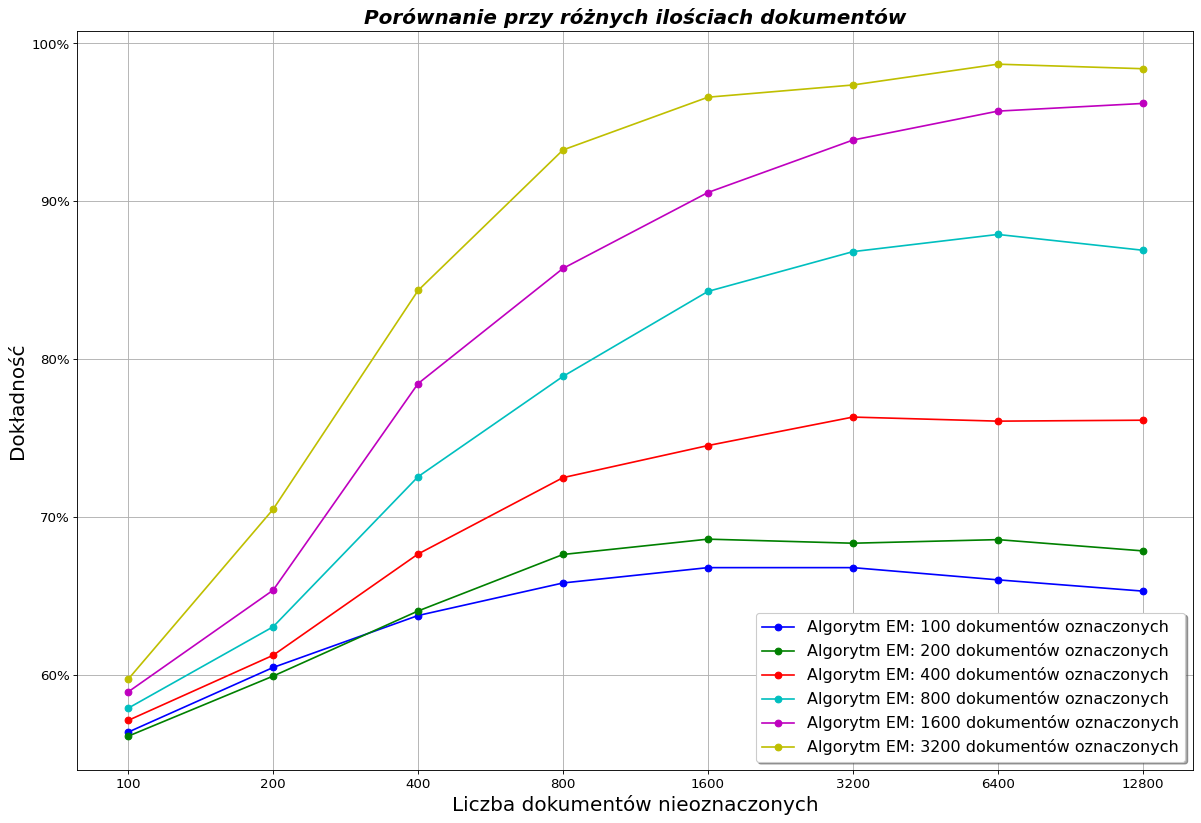

In [294]:
t = np.arange(0.0, len(em_scores[100]))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(18, 12), dpi=80)
# fig.set_figwidth(18)
# fig.set_figheight(12)

cols = ['b','g','r','c','m','y']
i = 0
for key in em_scores.keys():

    ax.plot(t, em_scores[key], "{}-o".format(cols[i]), label="Algorytm EM: {} dokumentów oznaczonych".format(key))
    i += 1

ax.set_title(
    "Porównanie przy różnych ilościach dokumentów",
    fontsize=18,
    fontweight="bold",
    style="italic",
)
ax.set_xticks(t, [100*2**r for r in range(8)])
ax.grid(True)
ax.set_ylabel("Dokładność", fontsize=18)
ax.set_xlabel("Liczba dokumentów nieoznaczonych", fontsize=18)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=12)
ax.set_xticklabels([100*2**r for r in range(8)], fontsize=12)

legend = ax.legend(loc="lower right", shadow=True, fontsize="x-large")

plt.show()


In [303]:
X_test, X_, y_test, y_ = train_test_split(X, y, test_size=0.9, random_state=42)

X_labeled_, X_unlabeled, y_labeled_, y_unlabeled = train_test_split(
        X_, y_, test_size=10000, random_state=42
    )


em_scores = []
mnb_scores = []
sgd_scores = []
lin_reg_scores = []
docs_n = []

step = 0.05
for r in np.arange(0 + step, 1, step):
    _, X_labeled, _, y_labeled = train_test_split(
        X_labeled_, y_labeled_, test_size=r, random_state=42
    )

    print('y_labeled: {}; y_unlabeled: {}'.format(y_labeled.count(), y_unlabeled.count()))

    n = y_labeled.count()
    docs_n.append(n)

    beta_ratio = y_labeled.sum() / y_unlabeled.count()

    # print('EM')
    em_mnb = semi_sup_EM_sklearn(alpha=0.385, beta=1, prnt=False)
    EM_sklearn_result = em_mnb.fit_EM(X_labeled, y_labeled, X_unlabeled, X_test)
    # print(confusion_matrix(np.array(y_test), em_mnb.predict(X_test)))
    # print(classification_report(np.array(y_test), em_mnb.predict(X_test)))

    score = balanced_accuracy_score(
        y_true=np.array(y_test), y_pred=em_mnb.predict(X_test)
    )

    em_scores.append(score)

    # print("mNB")
    classic_mnb = MultinomialNB()
    classic_mnb.fit(X_labeled, y_labeled)
    # print(confusion_matrix(np.array(y_unlabeled), classic_mnb.predict(X_unlabeled)))
    # print(classification_report(np.array(y_unlabeled), classic_mnb.predict(X_unlabeled)))

    score = balanced_accuracy_score(
        y_true=np.array(y_test), y_pred=classic_mnb.predict(X_test)
    )

    mnb_scores.append(score)

    sgd = Pipeline([#('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
    sgd.fit(X_labeled, y_labeled)

    score = balanced_accuracy_score(
        y_true=np.array(y_test), y_pred=sgd.predict(X_test)
    )

    sgd_scores.append(score)

    lin_reg = Pipeline([#('tfidf', TfidfTransformer()),
            ('clf', SGDClassifier(loss='log_loss', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
            ])
    lin_reg.fit(X_labeled, y_labeled)

    score = balanced_accuracy_score(
        y_true=np.array(y_test), y_pred=lin_reg.predict(X_test)
    )

    lin_reg_scores.append(score)

y_labeled: 343; y_unlabeled: 10000
y_labeled: 685; y_unlabeled: 10000
y_labeled: 1027; y_unlabeled: 10000
y_labeled: 1369; y_unlabeled: 10000
y_labeled: 1712; y_unlabeled: 10000
y_labeled: 2054; y_unlabeled: 10000
y_labeled: 2396; y_unlabeled: 10000
y_labeled: 2738; y_unlabeled: 10000
y_labeled: 3081; y_unlabeled: 10000
y_labeled: 3423; y_unlabeled: 10000
y_labeled: 3765; y_unlabeled: 10000
y_labeled: 4108; y_unlabeled: 10000
y_labeled: 4450; y_unlabeled: 10000
y_labeled: 4792; y_unlabeled: 10000
y_labeled: 5134; y_unlabeled: 10000
y_labeled: 5476; y_unlabeled: 10000
y_labeled: 5819; y_unlabeled: 10000
y_labeled: 6161; y_unlabeled: 10000
y_labeled: 6503; y_unlabeled: 10000


C:\Users\User\AppData\Local\Temp\ipykernel_7452\3911789672.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=12)


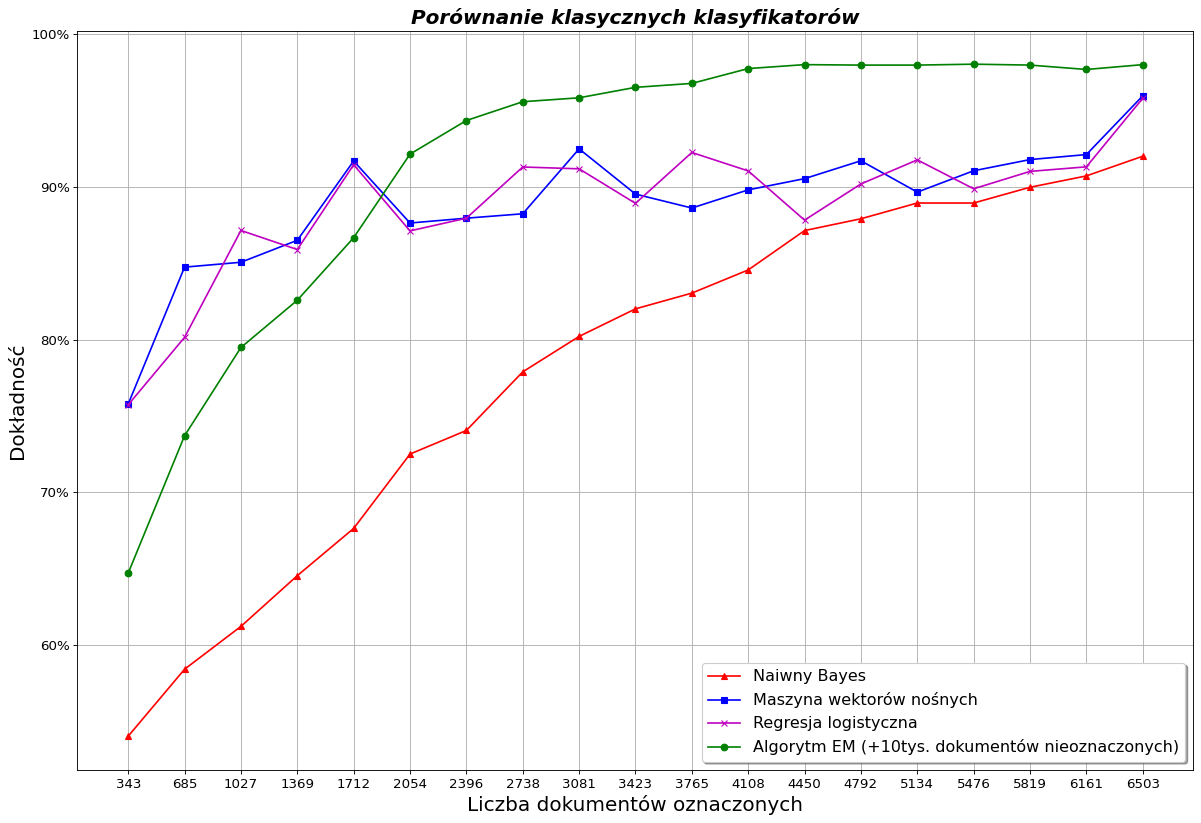

In [306]:
t = np.arange(0.0, len(em_scores))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(18, 12), dpi=80)
# fig.set_figwidth(18)
# fig.set_figheight(12)

ax.plot(t, mnb_scores, "r-^", label="Naiwny Bayes")
ax.plot(t, sgd_scores, "b-s", label="Maszyna wektorów nośnych")
ax.plot(t, lin_reg_scores, "m-x", label="Regresja logistyczna")
ax.plot(t, em_scores, "g-o", label="Algorytm EM (+10tys. dokumentów nieoznaczonych)")

ax.set_title(
    "Porównanie klasycznych klasyfikatorów",
    fontsize=18,
    fontweight="bold",
    style="italic",
)
ax.set_xticks(t, docs_n)
ax.grid(True)
ax.set_ylabel("Dokładność", fontsize=18)
ax.set_xlabel("Liczba dokumentów oznaczonych", fontsize=18)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=12)
ax.set_xticklabels(docs_n, fontsize=12)

legend = ax.legend(loc="lower right", shadow=True, fontsize="x-large")

plt.show()
